In [1]:
import pandas as pd
import ast
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
from collections import Counter
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import seaborn as sns

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sindr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
data=pd.read_csv('Hotel_Reviews.csv') #read the csv file

In [3]:
# This is the basic data cleaning process. This should be added in all the models
# This cell is a bit slow to run, so it is intended to be run only once

# This part drops the columns that are not needed in the model
data.drop('Hotel_Address',axis=1,inplace=True)  # Drop the column 'Hotel_Address' due to lack of relevance
data.drop('Review_Date',axis=1,inplace=True)    # Drop the column 'Review_Date' due to lack of complete data
data.drop('Additional_Number_of_Scoring',axis=1,inplace=True)  # Drop the column 'Additional_Number_of_Scoring' due to not knowing what the numbers mean
data.drop('lat',axis=1,inplace=True)    # Drop the column 'lat' due to lack of relevance
data.drop('lng',axis=1,inplace=True)    # Drop the column 'lng' due to lack of relevance
data.drop('Total_Number_of_Reviews',axis=1,inplace=True)    # Drop the column 'Total_Number_of_Reviews' due to the number seems to be incorrect


# The next part of the code aims to split the 'Tags' column into multiple columns

data['Tags'] = data['Tags'].apply(ast.literal_eval) # Convert the string to a list, This code is made by chatgpt

# The following 3 lines of code is made by github copilot

tags_expanded = data['Tags'].apply(pd.Series) # Expand the 'Tags' column into multiple columns

tags_expanded.columns = [f'Tag_{i}' for i in range(tags_expanded.shape[1])] # Rename the columns for better readability

data = pd.concat([data, tags_expanded], axis=1) # Concatenate the expanded tags with the original dataframe

data.drop('Tags',axis=1,inplace=True)   # Drop the column 'Tags' due to the data being split into multiple columns

# The next part of the code turns the 'days_since_review' and 'Tag_3' columns into integers
data['days_since_review']=data['days_since_review'].str.extract('(\d+)').astype(int) # Extract the number from the string. This code if made using chatgpt
data['Tag_3'] = data['Tag_3'].str.extract('(\d+)').astype(float) # Extract the number from the string and convert to float. For some reason it did not work as int

# The next part of the code creates a new dataframe with hotel names and removes it from the dataframe data
hotel_names = data['Hotel_Name'] # Create a new dataframe with the hotel names
data.drop('Hotel_Name',axis=1,inplace=True) # Drop the column 'Hotel_Name' as it is not needed in the model

<>:28: SyntaxWarning: invalid escape sequence '\d'
<>:29: SyntaxWarning: invalid escape sequence '\d'
<>:28: SyntaxWarning: invalid escape sequence '\d'
<>:29: SyntaxWarning: invalid escape sequence '\d'
C:\Users\sindr\AppData\Local\Temp\ipykernel_19424\4087391614.py:28: SyntaxWarning: invalid escape sequence '\d'
  data['days_since_review']=data['days_since_review'].str.extract('(\d+)').astype(int) # Extract the number from the string. This code if made using chatgpt
C:\Users\sindr\AppData\Local\Temp\ipykernel_19424\4087391614.py:29: SyntaxWarning: invalid escape sequence '\d'
  data['Tag_3'] = data['Tag_3'].str.extract('(\d+)').astype(float) # Extract the number from the string and convert to float. For some reason it did not work as int


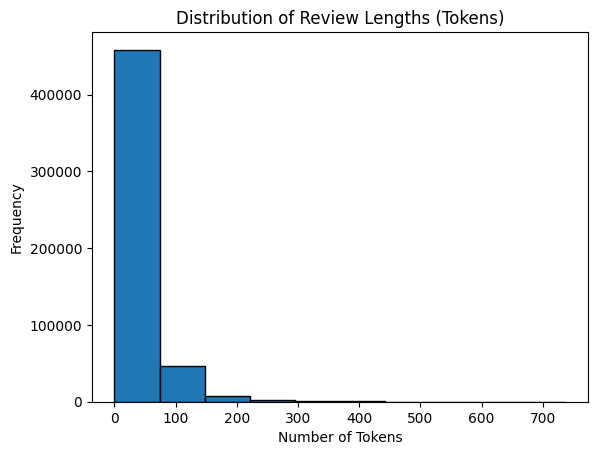

Max review length: 737
Min review length: 0
Average review length: 36.31590846515091
95th percentile review length: 191.0


Total number of unique words: 84122
max_vocab for 97.5% coverage: 5018 words


In [5]:
# Denne cellen kan ignoreres. Brukes bare til å finne verdier for MAX_LEN og MAX_VOCAB

df = data.copy()

review_lengths = df["Review_Total_Negative_Word_Counts"] + df["Review_Total_Positive_Word_Counts"]

reviews = df["Negative_Review"] + df["Positive_Review"]

# Tokenize the reviews and create a list of all words
all_words = [word for review in reviews for word in review.lower().split()]

# Count the frequency of each word
word_counts = Counter(all_words)

# Calculate cumulative sum of word frequencies
sorted_word_counts = sorted(word_counts.values(), reverse=True)
cumulative_sum = np.cumsum(sorted_word_counts)
total_words = sum(sorted_word_counts)

# Find unique words by converting the list of tokens to a set
unique_words = set(all_words)


# Plot the distribution of review lengths (number of tokens)
plt.hist(review_lengths, bins=10, edgecolor='black')
plt.title('Distribution of Review Lengths (Tokens)')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()

# Printing relevant information
print(f"Max review length: {max(review_lengths)}")
print(f"Min review length: {min(review_lengths)}")
print(f"Average review length: {np.mean(review_lengths)}")
print(f"95th percentile review length: {np.percentile(review_lengths, 99)}")
print("\n")
print(f"Total number of unique words: {len(unique_words)}")

# Finding ideal MAX_VOCAB 
# Prioriterer i dette tilfellet coverage over andel av unike ord, fordi det er LSTM modell og det er liten forskjell i coverage mellom 10000 og 2500 ord
# Initialize the desired coverage percentage
desired_coverage = 97.5

# Iterate over possible max_vocab values (or up to the length of cumulative_sum)
for max_vocab in range(1, len(cumulative_sum) + 1):
    # Get the cumulative sum for the top 'max_vocab' words
    coverage = cumulative_sum[max_vocab - 1]  # Take the cumulative sum at 'max_vocab' position
    
    # Calculate the coverage percentage
    coverage_percentage = (coverage / total_words) * 100
    
    # Check if the coverage has reached or exceeded the desired value
    if coverage_percentage >= desired_coverage:
        print(f"max_vocab for {desired_coverage}% coverage: {max_vocab} words")
        break  # Exit the loop as we've found the first match





In [ ]:
# Data preprocessing

data_lstm = data.copy()

# Binary variable to determine sentiment (1 if Reviewer_Score >= 5, else 0)
data_lstm['positive'] = (data_lstm['Reviewer_Score'] >= 5).astype(int)

# Text preprocessing
MAX_VOCAB = 5018 # 97.5% coverage
MAX_LEN = 106 # 95th percentile of tokens in review

data_lstm['Positive_Review'] = data_lstm['Positive_Review'].astype(str)
data_lstm['Negative_Review'] = data_lstm['Negative_Review'].astype(str)


tok = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tok.fit_on_texts(data_lstm['Positive_Review'] + data_lstm['Negative_Review'])

# Convert text to sequences
X_pos = tok.texts_to_sequences(data_lstm['Positive_Review'])
X_neg = tok.texts_to_sequences(data_lstm['Negative_Review'])

# Pad sequences
X_pos = pad_sequences(X_pos, maxlen=MAX_LEN, padding='post', truncating='post')
X_neg = pad_sequences(X_neg, maxlen=MAX_LEN, padding='post', truncating='post')

# Numerical variables
num_variables = ['Average_Score', 'Review_Total_Negative_Word_Counts',
                'Review_Total_Positive_Word_Counts', 'Total_Number_of_Reviews_Reviewer_Has_Given',
                'days_since_review']
scaler = StandardScaler()
X_num = scaler.fit_transform(data_lstm[num_variables])


# Label encoding used as opposed to one hot encoding, because it would be too memory intensive
# Label encode reviewer nationality
le_reviewer_nationality = LabelEncoder()
data_lstm['Reviewer_Nationality'] = le_reviewer_nationality.fit_transform(data_lstm['Reviewer_Nationality'])

# Convert 'Reviewer_Nationality' into a NumPy array and reshape for stacking
X_nationality = data_lstm['Reviewer_Nationality'].values.reshape(-1, 1)

tags = ['Tag_0', 'Tag_1', 'Tag_2', 'Tag_3', 'Tag_4', 'Tag_5']
# Label encode each tag column individually
for tag in tags:
    le_tags = LabelEncoder()
    data_lstm[tag] = le_tags.fit_transform(data_lstm[tag])  # Convert each tag into integer labels

X_tags = data_lstm[tags].values  # Convert to NumPy array

# Combine features
X = np.hstack((X_pos, X_neg, X_num, X_nationality, X_tags))
y = data_lstm['positive'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # stratify = y because of high level of imbalance in positive and negative reviews


# print(data_lstm.dtypes)  # Check overall data types
# print(data_lstm[['Reviewer_Nationality']].dtypes)  # Check the label-encoded column
# print(data_lstm[tags].dtypes)  # Check the tag columns (still one-hot encoded)

# print(Counter(data_lstm['positive'])) # Check ratio of positive to negative reviews

Counter({1: 493457, 0: 22281})


In [5]:


# Build LSTM model
model = Sequential([
    Embedding(MAX_VOCAB, 128, input_length=X_train.shape[1]),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])


c:\Users\sindr\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [6]:
# Train model
model.fit(X_train, y_train, epochs=1, batch_size=32, validation_data=(X_test, y_test))

12894/12894 ━━━━━━━━━━━━━━━━━━━━ 763s 59ms/step - AUC: 0.7780 - accuracy: 0.9576 - loss: 0.1484 - val_AUC: 0.9433 - val_accuracy: 0.9646 - val_loss: 0.0964


3224/3224 ━━━━━━━━━━━━━━━━━━━━ 56s 17ms/step


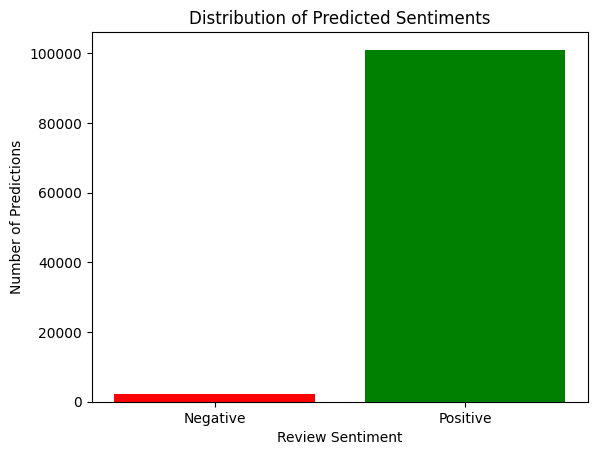

In [7]:
# Get raw predictions (probabilities)
y_pred_probs = model.predict(X_test)

# Convert probabilities to binary labels (assuming 0.5 threshold)
y_pred = (y_pred_probs >= 0.5).astype(int)

positive_count = np.sum(y_pred == 1)
negative_count = np.sum(y_pred == 0)

# Data for plotting
categories = ['Negative', 'Positive']
counts = [negative_count, positive_count]

# Create the histogram
plt.bar(categories, counts, color=['red', 'green'])

# Labels and title
plt.xlabel("Review Sentiment")
plt.ylabel("Number of Predictions")
plt.title("Distribution of Predicted Sentiments")

# Show plot
plt.show()

In [ ]:
# Evaluate model
test_loss, test_accuracy, test_AUC = model.evaluate(X_test, y_test)
train_loss, train_accuracy, train_AUC = model.evaluate(X_train, y_train)
print(f'Test Accuracy: {test_accuracy:.2f}')
print(f'Train Accuracy: {train_accuracy:.2f}')
print(f'Overfitting: {train_accuracy-test_accuracy}')

# Get predicted probabilities and convert them to binary (threshold = 0.5)
y_pred_prob = model.predict(X_test)  
y_pred = (y_pred_prob >= 0.5).astype(int)  # Convert to binary classification

# Compute classification metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)  # Use probabilities for ROC-AUC

# Print results
print(f'Accuracy: {accuracy:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1-Score: {f1:.3f}')
print(f'ROC-AUC: {roc_auc:.3f}')

3224/3224 ━━━━━━━━━━━━━━━━━━━━ 55s 17ms/step - AUC: 0.9455 - accuracy: 0.9643 - loss: 0.0962


ValueError: too many values to unpack (expected 2)

In [11]:
#This cell is designed specifically for the xgboost classifier model, but can be used in other models as well

xgb_data = data.copy() # Create a copy of the dataframe data
xgb_data.drop('Reviewer_Nationality',axis=1,inplace=True) # Drop the column 'Revierer_Nationality' as it will give to many columns when one hot encoded
xgb_data.drop('Negative_Review',axis=1,inplace=True) # Drop the column 'Negative_Review' as it is not a numeric value
xgb_data.drop('Positive_Review',axis=1,inplace=True) # Drop the column 'Positive_Review' as it is not a numeric value

xgb_data = pd.get_dummies(xgb_data, dtype=int) # One hot encode the data
print(xgb_data.head()) # Print the first 5 rows of the dataframe

   Average_Score  Review_Total_Negative_Word_Counts  \
0            7.7                                397   
1            7.7                                  0   
2            7.7                                 42   
3            7.7                                210   
4            7.7                                140   

   Review_Total_Positive_Word_Counts  \
0                                 11   
1                                105   
2                                 21   
3                                 26   
4                                  8   

   Total_Number_of_Reviews_Reviewer_Has_Given  Reviewer_Score  \
0                                           7             2.9   
1                                           7             7.5   
2                                           9             7.1   
3                                           1             3.8   
4                                           3             6.7   

   days_since_review  Tag_3  Tag_0_ B

In [15]:
# The next part of the code splits the data into training and testing data
x = xgb_data.drop('Reviewer_Score',axis=1) # Define the features
y = xgb_data['Reviewer_Score'] # Define the target
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=69) # Split the data into training and testing data